In [41]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install tensorflow torch torchvision torchaudio

In [6]:
import kagglehub
import os                                                ##  Modul os je součástí standardní knihovny Pythonu a umožňuje pracovat se soubory a adresáři v operačním systému. 
                                                         ##  Často se používá ke čtení/zápisu souborů, získání cest k souborům a manipulaci s adresáři. 

from PIL import Image                                    ## PIL (Python Imaging Library, dnes známá jako Pillow) je knihovna pro manipulaci s obrázky. 
                                                         ## Image umožňuje otevírat, upravovat a ukládat obrázky ve formátech jako PNG, JPEG, BMP atd. 

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split     ## Rozdělení datasetu na trénovací a testovací část
from keras.utils import to_categorical                   ##  Konverze štítků do One-Hot Encoding, Místo číselného označení jako 0, 1, 2, 
                                                         ##  což by mohlo způsobit chyby v učení (síť by mohla mylně považovat 2 za „větší“ než 1), použijeme One-Hot Encoding:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout
)
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from keras.applications import MobileNetV3Large     ## je předtrénovaný model hlubokého učení určený pro rozpoznávání obrazu.
                                                    ## Model je předtrénován na obrovském datasetu ImageNet a lze jej dále upravit (tzv. transfer learning).
from keras.layers import GlobalAveragePooling2D     ## redukuje dimenzionalitu výstupních dat.
from keras.models import Model                      ## Model umožňuje sestavit vlastní architekturu neuronové sítě v Kerasu.
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.regularizers import l2
from keras.utils import to_categorical

In [7]:
def plot_history(history):
  """
  Funkce na vykreslení dat z objectu history -> vrací ho metoda fit keras modelu
  """
  # plot the Loss curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)

  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
  plt.show()

  # plot the Accuracy curve(s)
  plt.figure(figsize=[8,6])

  plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
  plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Accuracy',fontsize=16)
  plt.title('Accuracy Curves',fontsize=16)
  plt.show()

## Načtení a preprocessing dat

In [28]:
path = r"C:\Users\zitao\Documents\PETR\DATA_SCIENCE\EMOCE"

In [29]:
fotky_emoce = os.listdir(f"{path}/train_OK")

In [30]:
# Načtení fotek a přiřazení názvů emocí ( labling)
X = []     
y = []     
encoding = {}   

for index, emoce in enumerate(fotky_emoce):        
  encoding[index] = emoce
  folder_path = os.path.join(f"{path}/train_OK", emoce)

  # Vytvoření datasetu
  image_list = []     
  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):    
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_resized = img.resize((48, 48))   # změna velikosto obrázku   
        img_array = np.array(img_resized)    # převod na numpy array
        image_list.append(img_array)         # rozšíření seznamu obrázků

  X += image_list    #   Přidáme všechny obrázky z této složky do seznamu X.
  y += [index] * len(image_list)  ## přiřazení čísel k labelům 

In [31]:
X = np.stack(X)
y = np.array(y)

In [32]:
# rozdělení, trénink test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
# one hot encoding y 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [33]:
# Zastavení trénování modelu, pokud nejsou změny větší než 0,3%
early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.003,
    patience=10,
    restore_best_weights=True,
)
# Uložení nejlepšího modelu
save = ModelCheckpoint(
    filepath="best_model_efficinetnet.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch"
)

## Trénování modelu na základě EfficientNET01

In [34]:
# Convert single-channel grayscale to 3-channel format (R=G=B=gray)
X = np.stack((X,) * 3, axis=-1)

In [35]:
X.shape

(13441, 48, 48, 3)

In [37]:
# vytvořit trénovací sadu z nenaškálovaných dat
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, stratify=y, random_state=42)       ##  20 % dat se použije pro testování, 80 % pro trénování,  42 - zajišťuje, že náhodné rozdělení bude stejné při každém spuštění.
                                                                       ## stratify=y – zajistí, že rozložení tříd (emocí) bude stejné v trénovacím i testovacím datasetu.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
# Načtení základního modelu MobileNetV3Large bez vrchní plně propojené vrstvy
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 3),
    name="efficientnetb0",
)

# Zamrznutí základního modelu, aby se jeho váhy během trénování neměnily
base_model.trainable = False

# Vytvoření vlastních vrstev pro specifickou úlohu
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    ## model.add(Dropout(0.5))
    layers.Dense(len(fotky_emoce), activation='softmax')  # 'num_classes' je počet tříd ve vašem datasetu
])

# Kompilace modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,442 (16.08 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [42]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32, callbacks=[early, save])

Epoch 1/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - accuracy: 0.4370 - loss: 1.5313 - val_accuracy: 0.5634 - val_loss: 1.2184
Epoch 2/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.5326 - loss: 1.2837 - val_accuracy: 0.5723 - val_loss: 1.1807
Epoch 3/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.5505 - loss: 1.2288 - val_accuracy: 0.5835 - val_loss: 1.1614
Epoch 4/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 37s 110ms/step - accuracy: 0.5554 - loss: 1.2218 - val_accuracy: 0.5749 - val_loss: 1.1500
Epoch 5/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.5643 - loss: 1.1915 - val_accuracy: 0.5898 - val_loss: 1.1382
Epoch 6/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.5684 - loss: 1.1942 - val_accuracy: 0.5924 - val_loss: 1.1075
Epoch 7/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 34s 100ms/step - accuracy: 0.5826 - loss: 1.1610 - val_accuracy: 0.6114 - val_loss: 1.0720
Epoch 8/100
336/336 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.5886 -

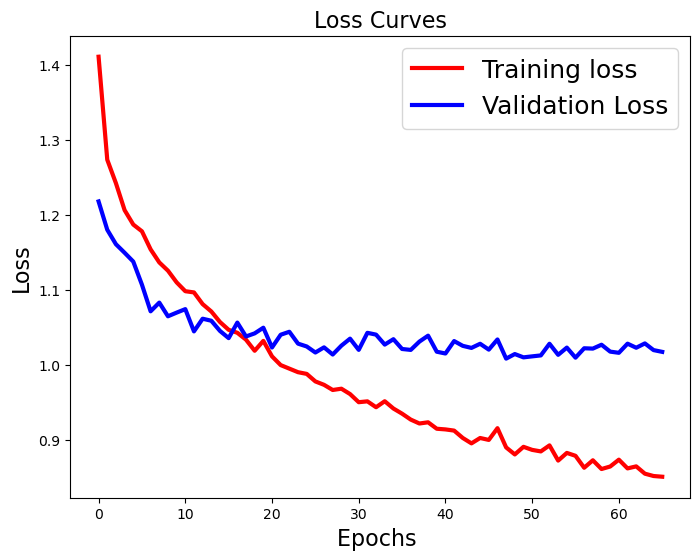

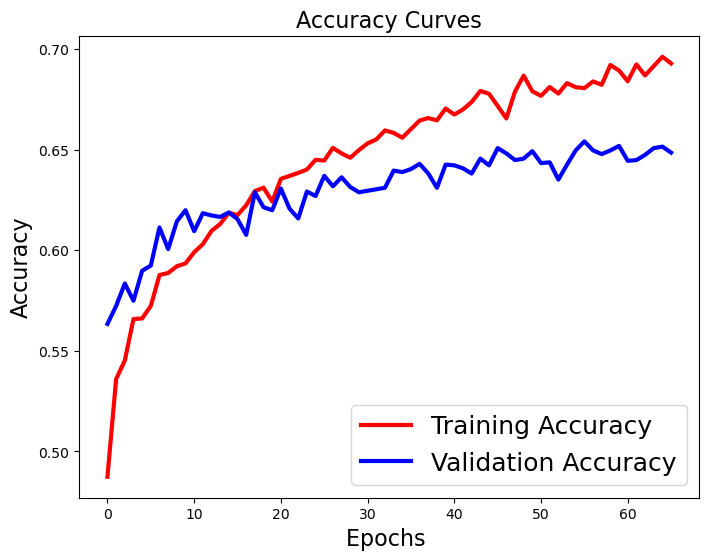

In [43]:
plot_history(history)

In [44]:
model = load_model("best_model_efficinetnet.keras")

In [45]:
y_pred = model.predict(X_test)

85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step


In [46]:
y_pred = np.argmax(y_pred, axis=1)

In [47]:
y_test = np.argmax(y_test, axis=1)

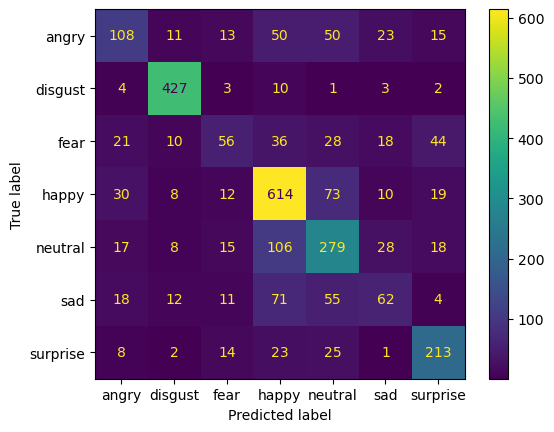

In [48]:
## plt.title("Confusion Matrix  - Vlastní neuronka")  # Název grafu

class_labels = list(encoding.values())
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()